In [1]:
import calliope

In [2]:
try:
    calliope.set_log_level('INFO')
except:
    calliope.set_log_verbosity('INFO')
model = calliope.Model('model.yaml')
model.run()

[2020-08-19 15:35:43] INFO     Model: initialising
[2020-08-19 15:35:44] WARNING  C:\Users\Amin\Anaconda3\envs\calliope\lib\site-packages\calliope\core\preprocess\model_run.py:227: FutureWarning:

There will be no default cost class for the objective function in v0.7.0 (currently "monetary" with a weight of 1). Explicitly specify the cost class(es) you would like to use under `run.objective_options.cost_class`. E.g. `{"monetary": 1}` to replicate the current default.


[2020-08-19 15:35:44] INFO     Model: preprocessing stage 1 (model_run)
[2020-08-19 15:35:44] INFO     NumExpr defaulting to 4 threads.
[2020-08-19 15:35:44] INFO     Model: preprocessing stage 2 (model_data)
[2020-08-19 15:35:45] INFO     Model: preprocessing complete
[2020-08-19 15:35:45] INFO     Backend: starting model run
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lifetime) to be 'Any', you can suppress
    this warning by explicitly specifying 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (resource_unit) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (resource_unit) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (resource_unit) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATE

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_remotes) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_remotes) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_remotes) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPREC

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (colors) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (colors) to be 'Any', you can
suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (colors) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (inheritance) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (inheritance) to be 'Any', you
can suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (inheritance) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (names) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (names) to be 'Any', you can
suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (names) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_carriers) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_carriers) to be
'Any', you can suppress this warning by explicitly specifying
'within=Any' to the Param constructor.  (deprecated in 5.6.9, will be
removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_carriers) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-19 15:35:47] WARNING  

In [3]:
import cal_graph as CG
amin=CG.C_Graph(model=model,ex_path=r'C:\Users\Amin\Documents\GitHub\My Kenya\Calliope_Kenya\Models\4Nodes_No-Coffee\Graph_inputs.xlsx',unit='kWh')
#amin.node_dispatch(unit='TWh',title_font=15,average='hourly',sp_techs=['bio_pp','geo_pp'],sp_nodes=['WSTR'])


C_Graph: A python class for customizing calliope outputs developed in Fondazione Eni Enrico Mattei. 
 Version 0.1: (Single Carrier)


In [ ]:
amin.sys_dispatch(rational='nodes',sp_nodes='WSTR')

[2020-08-19 15:35:55] WARNING  C:\Users\Amin\Anaconda3\envs\calliope\lib\site-packages\pandas\plotting\_matplotlib\core.py:201: UserWarning:

'colors' is being deprecated. Please use 'color'instead of 'colors'




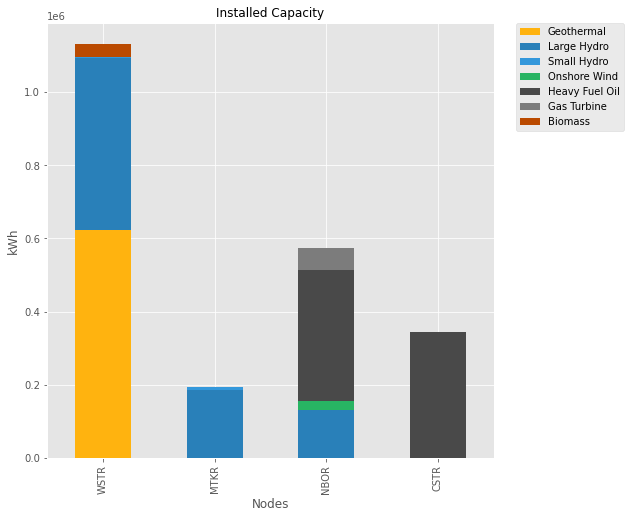

In [4]:
amin.ins_cap_plot(kind='bar')

In [ ]:
a=amin.ins_cap_plot.fillna(0)

In [ ]:
a.columns = a.columns.to_list()

In [ ]:

a.T.plot(kind='bar',stacked=True,colors=colors[a.index],figsize=(8,8))
plt.title('a')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=True,labels=names[a.index])

plt.xlabel('UNIT')

In [ ]:
amin.node_pie(v_round=0,unit='GWh',title_font=15,kind='share',fig_format='svg')

In [ ]:
import pandas as pd

In [ ]:
Dem_Tech = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Consumption Techs',index_col=[0],header=[0])
Nodes    = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Nodes',index_col=[0],header=[0])
Pr_Techs = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Production Techs',index_col = [0],header=[0])
colname  = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Col_Name',index_col = [0],header =[0])
imp_exp  = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'imp-exp',index_col = [0],header =[0])
Trans    = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Transmission',index_col = [0],header =[0])
date     = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Date',index_col = [0],header =[0])

In [ ]:
co_techs = Dem_Tech['Tech'].to_list()
carr     = Dem_Tech['Carrier'].to_list()
nodes    = Nodes['Location'].to_list()
pr_techs = Pr_Techs['Tech'].to_list()
colors   = colname['Color']
names    = colname['Name']
imps     = imp_exp['Imports'].to_list()
exps     = imp_exp['Exports'].to_list()
tr_tech  = Trans['Tech'].to_list()
start    = date['Value'][0]
end      = date['Value'][1]

In [ ]:
carr

In [ ]:
# How to build the transmissions

In [ ]:
RES_ind = []
for i in range(len(pr_techs)):
    if Pr_Techs['RES'][i] == 1:
        RES_ind.append('Renewable')
    else:
        RES_ind.append('Conventional')

In [ ]:
RES_ind = RES_ind * len(nodes)

In [ ]:
model.get_formatted_array('carrier_prod').loc[{'techs':pr_techs,'carriers':'power','locs':nodes}].to_pandas().T

In [ ]:
pr = model.get_formatted_array('carrier_prod').loc[{'techs':pr_techs,'carriers':'power','locs':[nodes[0]]}].sum('locs').to_pandas().T
pr = pd.concat([pr],keys=[nodes[0]],axis=1)
for i in  range (1,len(nodes)):
    pr0 = model.get_formatted_array('carrier_prod').loc[{'techs':pr_techs,'carriers':'power','locs':[nodes[i]]}].sum('locs').to_pandas().T
    pr0 = pd.concat([pr0],keys=[nodes[i]],axis=1)
    pr = pd.concat([pr,pr0],axis=1)
    
    
    

In [ ]:
pr.groupby(level=1,axis=1).sum()

In [ ]:
node = nodes[0]

r_nodes = nodes.copy()
r_nodes.remove(node)

exp = r_nodes.copy()
imp = r_nodes.copy()
    
node_index = []
    
for j in range(len(r_nodes)):
        
    node_index.append(nodes[0]) 
    node_index.append(nodes[0]) 
        
    exp[j] = exp[j] + '_exp'
    imp[j] = imp[j] + '_imp'

exports = pd.DataFrame(index=pr.index,columns=exp)
imports = pd.DataFrame(index=pr.index,columns=imp)


tran_get = []

for i in r_nodes:
    tr = []
    for j in tr_tech:
        tr.append(j + ':' + i)
    tran_get.append(tr)

for i in range(len(exp)):
    exports[exp[i]] = model.get_formatted_array('carrier_con').loc[{'techs':tran_get[i],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T
    imports[imp[i]] = model.get_formatted_array('carrier_prod').loc[{'techs':tran_get[i],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T

imports = pd.concat([imports],keys=[node],axis=1)
exports = pd.concat([exports],keys=[node],axis=1)
    
for i in range(1,len(nodes)):
    node = nodes[i]
    r_nodes = nodes.copy()
    r_nodes.remove(node)
    
    
    exp = r_nodes.copy()
    imp = r_nodes.copy()
    
    node_index = []
    
    for j in range(len(r_nodes)):
        
        node_index.append(nodes[i]) 
        node_index.append(nodes[i]) 
        
        exp[j] = exp[j] + '_exp'
        imp[j] = imp[j] + '_imp'   
        
    exports0 = pd.DataFrame(0,index=pr.index,columns=exp)
    imports0 = pd.DataFrame(0,index=pr.index,columns=imp)
    

    tran_get = []

    for h in r_nodes:
        tr = []
        for p in tr_tech:
            tr.append(p + ':' + h)
        tran_get.append(tr)

    for n in range(len(exp)):
        exports0[exp[n]] = model.get_formatted_array('carrier_con').loc[{'techs':tran_get[n],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T
        imports0[imp[n]] = model.get_formatted_array('carrier_prod').loc[{'techs':tran_get[n],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T

    imports0 = pd.concat([imports0],keys=[node],axis=1)
    exports0 = pd.concat([exports0],keys=[node],axis=1)
    
    imports = pd.concat([imports,imports0],axis=1)
    exports = pd.concat([exports,exports0],axis=1)

In [ ]:
demand = -model.get_formatted_array('carrier_con').loc[{'techs':co_techs,'carriers':carr,'locs':nodes}].sum('techs').sum('carriers').to_pandas().T

In [ ]:
a=demand.sum(axis=1)

In [ ]:
print('/tec/')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
plt.style.use('seaborn-colorblind')

col_list_pr = []
name_list_pr = []

prod = pd.concat([pr['WSTR'],imports['WSTR']],axis=1)


fig, (ax1) = plt.subplots(1, figsize=(8,6))
ax1.margins(x=0)
ax1.margins(y=0.1)

plt.plot(demand['WSTR'].index,demand['WSTR'].values,'black', alpha=0.5, linestyle = '--', label ='Demand',linewidth=3)

plt.stackplot(pr['WSTR'].index,pr['WSTR'].values.T,colors=colors[prod.columns],labels=names[prod.columns])

plt.stackplot(pr['WSTR'].index,exports['WSTR'].values.T,colors=colors[exports['WSTR'].columns],labels=names[exports['WSTR'].columns])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=True)
plt.title("Electricity Production",fontsize=15)

#plt.yticks(fontweight='bold')

xfmt = mdates.DateFormatter('%d/%m/%y , %H:%M')
ax1.xaxis.set_major_formatter(xfmt)

plt.xlabel('Date')
plt.xticks(rotation=70)
plt.savefig('Graphs\Pie_System_Result.{}'.format('png'), dpi=fig.dpi,bbox_inches='tight')

In [ ]:
converter = {'Wh':1,'kWh':10**3,'MWh':10**6,'GWh':10**9,'TWh':10**12}

In [ ]:
unit1,unit2= 'Wh','kWh'


In [ ]:
converter[unit2]/converter[unit1]

In [ ]:
units = ['Wh','kWh','MWh','GWh','TWh']
a='ah'

print('{} hi'.format(units))


In [ ]:
sp_tech=['bio_pp']
fig, (axs) = plt.subplots(2, figsize=(8,10),sharex=True)
gs = gridspec.GridSpec(2, 1,height_ratios=[3,1]) 
axs[1] = plt.subplot(gs[1])
axs[0] = plt.subplot(gs[0],sharex=axs[1])
plt.setp(axs[0].get_xticklabels(), visible=False)
col_list_pr = []
name_list_pr = []
prod = pd.concat([pr['WSTR'],imports['WSTR']],axis=1)



axs[0].margins(x=0)
axs[0].margins(y=0.1)

axs[0].plot(demand['WSTR'][start:end].index,demand['WSTR'][start:end].values,'black', alpha=0.5, linestyle = '--', label ='Demand',linewidth=3)

axs[0].stackplot(pr['WSTR'].index,pr['WSTR'].values.T,colors=colors[prod.columns],labels=names[prod.columns])

axs[0].stackplot(pr['WSTR'].index,exports['WSTR'].values.T,colors=colors[exports['WSTR'].columns],labels=names[exports['WSTR'].columns])

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=True)
plt.title("Electricity Production",fontsize=15)

axs[1].stackplot(pr['WSTR'].index,pr['WSTR'][sp_tech].values.T,colors=colors[sp_tech])

plt.yticks(fontweight='bold')

xfmt = mdates.DateFormatter('%d/%m/%y , %H:%M')
axs[1].xaxis.set_major_formatter(xfmt)


axs[1].tick_params(axis='x', rotation=70)

#axs.xticks(rotation=70)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax1.pie(pr['WSTR'].sum(),shadow=False,colors=colors[pr_techs])
am = pd.DataFrame(pr['WSTR'].sum().values,columns=['Production'],index = pr['WSTR'].columns)
am = am/1000000000
am = am.round(4)
plt.style.use('seaborn')

ax2.patch.set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

table = ax2.table(cellText=am.values,
                              rowColours=colors[pr_techs],
                              rowLabels= names[pr_techs],
                              colLabels = ['TWh'],
                              loc='center right',
                              rowLoc ='center',
                              colLoc='center',
                              cellLoc='center')

table.scale(0.4, 3)
table.auto_set_font_size(False)
table.set_fontsize(15)
fig.suptitle('This is a somewhat long figure title', fontsize=16)

In [ ]:
am

In [ ]:
from fpdf import FPDF

In [ ]:
class PDF(FPDF):
    pass

In [ ]:
am=-am

In [ ]:
am=am.values

In [ ]:
am

In [ ]:
pr['WSTR']

In [ ]:
imports

In [ ]:
pdf=PDF(orientation='L')
pdf=PDF(unit='mm') #unit of measurement
pdf=PDF(format='A4')
pdf.add_page()


# size of an A4 paper: W:210 , h:297
pdf_w = 210
pdf_h = 297

pdf.set_xy(0.0,0.0)
pdf.set_font('Arial','B',16)
pdf.set_text_color(220,50,50)
pdf.cell(w=210.0, h=40.0, align='C', txt="Summary of the Model", border=0)

pdf.set_xy(40.0,25.0)
#pdf.image(r'C:\Users\Amin\Documents\GitHub\My Kenya\Calliope_Kenya\Models\4Nodes_No-Coffee\Graphs\MTKR_16OP.png',  link='', type='', w=700/5, h=450/5)
data = [[' '],
        ['Mike', 'Driscoll', 'mike@somewhere.com', '55555'],
        ['John', 'Doe', 'jdoe@doe.com', '12345'],
        ['Nina', 'Ma', 'inane@where.com', '54321']
            ]
col_width = pdf.w / 4.5
pdf.set_font("Arial", size=12)
row_height = pdf.font_size
for row in data:
    for item in row:
        pdf.cell(col_width, row_height*1,
                     txt=item, border=1)
    pdf.ln(row_height*1)
pdf.output('test.pdf','F')

In [ ]:
energy_cap=model.get_formatted_array('energy_cap_equals').loc[{'techs':pr_techs,'locs':nodes}].to_pandas().T

In [ ]:
energy_cap=energy_cap.fillna(0)

In [ ]:
energy_cap

In [ ]:
nodes

In [ ]:
fig,(ax) = plt.subplots(1,figsize=(8,8))

table = plt.table(cellText=energy_cap.values,
                              rowColours=colors[pr_techs],
                              rowLabels= names[pr_techs],
                              colLabels = nodes,
                              loc='upper center',
                              rowLoc ='center',
                              colLoc='center',
                              cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(1, 2)
plt.box(on=None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Installed Capacity',fontsize=20)

plt.savefig('pyplot-table-figure-style.png',
            bbox_inches='tight',
            dpi=150
            )

In [ ]:
cap_f=model.get_formatted_array('capacity_factor').loc[{'techs':pr_techs,'locs':['WSTR'],'carriers':'power'}].sum('locs').to_pandas().T

In [ ]:
cap_f=cap_f.sum()/len(cap_f)

In [ ]:
cap_f.plot(kind='bar',colors=colors[pr_techs])

In [ ]:
a = model.get_formatted_array('cost').loc[{'techs':pr_techs,'locs':['WSTR'],'costs':'monetary'}].sum('locs').to_pandas().T

In [ ]:
a.plot(kind='bar',stacked=True)

In [ ]:
import cal_graph as CG
amin=CG.C_Graph(model=model,ex_path=r'C:\Users\Amin\Documents\GitHub\My Kenya\Calliope_Kenya\Models\4Nodes_No-Coffee\Graph_inputs.xlsx',unit='kWh')
amin.node_dispatch(unit='GWh')

In [ ]:
a=['1']

In [ ]:
if a:
    print('hi')

In [ ]:
amin.node_dispatch(unit='GWh')

In [ ]:
pr['WSTR']

In [ ]:
pr['WSTR'].resample('1h').mean()

In [ ]:
pr.columns = [pr.columns.get_level_values(0),RES_ind]

In [ ]:
pr=pr.groupby(level=[0,1],axis=1).sum()

In [ ]:
shares = pd.DataFrame(0,index = pr.index , columns = pr.columns)

In [ ]:
for i in nodes:
    shares[(i,'Renewable')] = pr[(i,'Renewable')] / pr[i].sum(axis=1)
    shares[(i,'Conventional')] = pr[(i,'Conventional')] / pr[i].sum(axis=1)

In [ ]:
a=pr[('CSTR','Conventional')]

In [ ]:
b=pr['CSTR'].sum(axis=1)

In [ ]:
shares*100

In [ ]:
pr['CSTR']